# 3D volume rendering of geophysical data using the yt platform

A notebook submission to the 2020 EarthCube Annual Meeting

To view a static rendering of this notebook, visit https://nbviewer.jupyter.org/github/chrishavlin/yt_velmodel_vis/blob/ecubeNtbook/notebooks/Notebook_3DseismicVis.ipynb

**Authors**: Christopher Havlin<sup>1</sup>,  Benjamin Holtzman<sup>1</sup>, Kacper Kowalik<sup>2</sup>, Madicken Munk<sup>2</sup>, Sam Walkow<sup>2</sup>, Matthew Turk<sup>2</sup> 

1. Lamont-Doherty Earth Observatory, Columbia University 
2. University of Illinois Urbana-Champagne 

## 1. Abstract 

We present novel applications of yt, a tool originally designed for analysis of astrophysics datasets, to the geosciences. yt is a python-based platform for volumetric data, which enables semantically meaningful analysis and visualization. As part of a wider effort to bring yt to the geosciences, we present an initial use-case of yt applied to 3D seismic tomography models of the upper mantle from the IRIS Earth Model Collaboration. While the rendering capabilities of yt can in general be applied directly to 3D geoscience data, we add several graphical elements to the 3D rendering to aid in interpretation of volume renderings including latitude/longitude overlays and shapefile suport for plotting political and tectonic boundaries along the Earth’s surface. In this notebook, we focus on tomographic models of North America and the Western U.S., where high resolution models and rapidly varying seismic properties provide a rich dataset to explore systematically at a range of lengthscales. The notebook demonstrates loading and rendering of IRIS netcdf models, highlighting interesting 3D features of the Western U.S. upper mantle, and goes on to demonstrate how having direct control of the transfer functions used in creating the final volume rendering allows for a more systematic exploration of the role of the visualization method in our interpretation of 3D volumetric data. Finally, we conclude by demonstrating some of the semantically-aware capabilities of yt for analysis purposes, and demonstrate how these tools have cross-disciplinary functionality.

## 2. Background

paragraph: **yt intro**. volume rendering overview. some citations for use in astrophysics, other domains. 

The present work demonstrates a use-case of *yt* in visualizing upper mantle geophysical data. Geophysical data contains rich 3D structure that maps the material properties of the upper mantle, including elastic properties (shear wave and compressional wave velocities, attenuation) and electrical properties (conductivity or restitivity). While 3D structure is inherent to all geophysical datasets, 3D visualization is not commonly used by researchers and most studies use 2D slices through the 3D data. In the occasional studies where 3D visualization is used, authors rely on 3D isosurfaces (e.g., Obreski et al. 2010) and while isosurfaces can reveal 3D structure, the noisy nature of the data results in significantly different ermergent structure depending on small deviations in the chosen value for an isosurface. As opposed to rendering isosurfaces, 3D volume rendering (using *yt*) allows the user to map a range of values and systematically explore how their choices influence their final interpretation.

In this notebook, we focus on a single tomographic model **NWUS11-S**, which maps shear wave velocity anomalies, $dV_s$, in the northwest United States (James et al., 2011). The upper mantle beneath the northwest U.S. contains rapid variations in material properties due to the wide range of regional tectonic processes including subduction of the Pacific plate beneath the Cascades and voluminious volcanic activity for the past ~50 Myrs including the Yellowstone Hot Spot (citation). This way in which the surficial tectonic processes map to upper mantle variability provides insights into the processes driving mantle convection and plate tectonics. Additionally,  **NWUS11-S** leveraged data from the Earthscope‐USArray seismic network to achieve a relatively high spatial resolution of the regional upper mantle, providing an ideal set of data to test *yt* in visualizing seismic data. Furthermore, because **NWUS11-S** is one of the models included in the Incorporated Research Institutions for Seismology (IRIS) Earth Model Collaboration (EMC) using the standardized netCDF format for 3-D models (citation), the code developed in the present repository is reasonably general and other models can be easily loaded.

## 3. Overview of Notebook

In the following notebook, sections 4 and 5 demonstrate how to load uniformally gridded geophysical data sets into *yt* and how to set transfer functions for volume rendering to highlight ranges of data, respectively. Together, these sections demonstrate the typical workflow for loading and rendering:

1. initialize the *yt* scene: load data volume source and add annotation volume sources
2. set the viewing angle with a camera object
3. set the transfer function (how the data is rendered).     

To modify this notebook, whether running a local jupyter server or running the binder-docker image, first run all cells to ensure the required packages are loaded and functions defined. 


### 3.1 Notebook Initialization: importing packages 

We begin by importing the libraries and setting required environment variables. In addition to the standard `yt` library, the present notebook relies on a supplementary `yt_velmodel_vis` library (https://github.com/chrishavlin/yt_velmodel_vis, the home of the present notebook) that facilitates data loading and transformations for seismic data as described below.

In [1]:
# imports and initialization (not editable)
import os, yt, numpy as np
import matplotlib.pyplot as plt
from yt_velmodel_vis import seis_model as SM,shapeplotter as SP, transferfunctions as TFs
from IPython.display import Image 

os.environ['YTVELMODELDIR']='./data' # local repo path to data directory 

The `yt_velmodel_vis` package uses a simple filesystem database in which raw model files, interpolated model files and shapefiles for annotation are stored in the directory set by the `YTVELMODELDIR` environment variable. For normal usage outside this notebook, after installing `yt_velmodel_vis`, a user can set this environment variable to any directory and run the following from a Python interpretter to initialize the database:

```
from yt_velmodel_vis import datamanager as dm
dm.initializeDB()
```

This will setup the local filesystem database, building the expected file tree structure and fetching some initial data including IRIS models and useful shapefiles. Once files stored within the filesystem database, the user needs to only supply the filename, not the complete path (as long as file names are unique). In the case of the shapefiles, there are also short-names for easier access. If loading a file outside the databse, the filenames must be full paths. In the above cell, we set the data directory relative to the location of the present notebook within the github repository, which already contains the data required for the notebook.

## 4. Loading IRIS Earth Model Collaboration (EMC) Files

The IRIS EMC (Trabant et al., 2012,http://ds.iris.edu/ds/products/emc-earthmodels/) is a rich database of geophysical models that serves as an excellent testing ground for using *yt* with geophysical data. As the 3D EMC models are standardized netCDF files, different models can be easily interchanged.

At present, the initialization workflow for loading 3D IRIS EMC models with *yt* consists of (4.1) interpolation and (4.2) annotation. 

### 4.1 Interpolation 
At present, 3D volume rendering in *yt* is restricted to cartesian coordinates, but IRIS EMC files are in geo-spherical coordinates (i.e., latitude, longitude and depth). A spherical volume rendering module is in development, but for the current demonstration we must first interpolate from spherical to cartesian coordinates. The `yt_velmodel_vis.seis_model` class contains a KDTree-Inverse Distance Weighting algorithm to populate values on the cartesian grid by finding the nearest N model data and weighting the values by distance from the point on the new cartesian grid.

While the resolution of the cartesian grid, number of nearest neighbors and max distance allowed in the nearest neighbor search are all adjustable parameters, the interpolation from spherical to cartesian coordinates is computationally demanding and so the current notebook loads a pre-built interpolation included in the respository data directory (`notebooks/data/`) for **NWUS11-S**, defined by the interpolation dictionary (`interp_dict`) in the following code cell. 


In [2]:
# load interpolated data using the yt uniform grid loader (not editable)

# set the model file and the field to visualize
modelfile='NWUS11-S_percent.nc' # the model netCDF file 
datafld='dvs' # the field to visualize, must be a variable in the netCDF file

# set the interpolation dictionary. If the interpolation for this model does 
# not exist, SM.netcdf() will build it. 
interp_dict={'field':datafld,'max_dist':50000,'res':[30000,30000,30000],
              'input_units':'m','interpChunk':int(1e7)}

# load the model 
model=SM.netcdf(modelfile,interp_dict)

# set some objects required for loading in yt 
bbox = model.cart['bbox'] # the bounding box of interpolated cartesian grid
data={datafld:model.interp['data'][datafld]} # data container for yt scene

# load the data as a uniform grid, create the 3d scene
ds = yt.load_uniform_grid(data,data[datafld].shape,1.0,bbox=bbox,nprocs=1,
                        periodicity=(True,True,True),unit_system="mks")

print("Data loaded.")

yt : [INFO     ] 2020-05-12 09:18:44,216 Parameters: current_time              = 0.0
yt : [INFO     ] 2020-05-12 09:18:44,216 Parameters: domain_dimensions         = [95 90 79]
yt : [INFO     ] 2020-05-12 09:18:44,217 Parameters: domain_left_edge          = [-5201282.   -3445670.25  2740212.5 ]
yt : [INFO     ] 2020-05-12 09:18:44,217 Parameters: domain_right_edge         = [-2328344.5     -735306.5625  5113796.5   ]
yt : [INFO     ] 2020-05-12 09:18:44,217 Parameters: cosmological_simulation   = 0.0


Data loaded.


### 4.2 Loading IRIS EMC Files: Building the scene 

The `yt.scene` object contains the information on how and what to render. In addition to specifying which field of the data to render, we can add annotations. While *yt* has methods for adding annotations to a volume rendering, because we want to add annotations reflecting the original spherical domain, we use routines in the `yt_velmodel_vis` package to manually add annotations as line and point sources.

Additionally, as opposed to the astrophysical datasets that *yt* was originally designed for, interpretation of geophysical datasets typically requires correlation along one boundary of the 3D data (the Earth's surface). The surficial expression of plate tectonics is directly related to the material properties of the underlying mantle, and so any 3D visualization of geophysical data requires some level of mapping to the regional tectonics at the Earth's surface. And so the `yt_velmodel_vis.shapeplotter` module contains routines to facilitate plotting shapes at the Earth's surface in the 3D view including latitude and longitude grids and automated parsing and transformation of shapefiles. The `shapeplotter` modulue leverages the `geopandas` library for automating the reading of shapefiles and includes transformations from geo-spherical coordinates to geocentric cartesian coordinates. 

In the present visualizations, we include tectonic boundaries (Coffin et al., 1998), sites of volcanism of the last 10,000 years (Simkin and Siebert, 1994) and US political boundaries (Natural Earth, https://www.naturalearthdata.com/). 

In [3]:
def build_yt_scene():
    """ builds the yt scene: 
    
    - Draws the spherical chunk bounding the dataset 
    - Draws a latitude/longitude grid at surface
    - Draws shapefile data: US political boundaries, tectonic boundaries, volcanos 
    
    """
    
    # create the scene 
    sc = yt.create_scene(ds,datafld)    
    
    # specifiy the bounds of the spherical chunk: used for annotating the domain
    lat_rnge=[np.min(model.data.variables['latitude']),np.max(model.data.variables['latitude'])]
    lon_rnge=[np.min(model.data.variables['longitude']),np.max(model.data.variables['longitude'])]
    min_dep=0.
    max_dep=1200.
    R=6371.
    r_rnge=[(R-max_dep)*1000.,(R-min_dep)*1000.]
    
    # build the spherical chunk, add domain extents and lat,lon grid annotations     
    Chunk=SP.sphericalChunk(lat_rnge,lon_rnge,r_rnge)
    sc=Chunk.domainExtent(sc,RGBa=[1.,1.,1.,0.002],n_latlon=100,n_rad=50)
    sc=Chunk.latlonGrid(sc,RGBa=[1.,1.,1.,0.005])
    sc=Chunk.latlonGrid(sc,RGBa=[1.,1.,1.,0.002],radius=(R-410.)*1000.)
    sc=Chunk.latlonGrid(sc,RGBa=[1.,1.,1.,0.002],radius=(R-max_dep)*1000.)
    sc=Chunk.wholeSphereReference(sc,RGBa=[1.,1.,1.,0.002])

    # Shapefile data
    
    # set the surficial bounding box, used for reading all shapefiles
    shp_bbox=[lon_rnge[0],lat_rnge[0],lon_rnge[1],lat_rnge[1]] 

    # US political boundaries 
    thisshp=SP.shapedata('us_states',bbox=shp_bbox,radius=R*1000.)
    sc=thisshp.addToScene(sc)

    # tectonic boundaries: buid a dictionary with unique RGBa values for each
    clrs={
        'transform':[0.8,0.,0.8,0.05],
        'ridge':[0.,0.,0.8,0.05],
        'trench':[0.8,0.,0.,0.05],
        'global_volcanos':[0.,0.8,0.,0.05]
    }
    for bound in ['transform','ridge','trench','global_volcanos']:
        tect=SP.shapedata(bound,radius=R*1000.,buildTraces=False)
        sc=tect.buildTraces(RGBa=clrs[bound],sc=sc,bbox=shp_bbox)
        
    return sc   

In the preceeding code, data from each shapefile is added in two steps:

1. Loading and parsing the shapefile, `SP.shapedata()`
2. Adding the shapefile traces to the *yt* scene `SP.shapedata.addToScene()` or `SP.shapedata.buildTraces()`

When loading the shapefile, the `radius` argument specifies what radius to draw the shapes at (in the above cases, drawing tectonic boundaries at the Earth's surface). The traces are added as a `LineSource` or `PointSource` from the *yt* volume rendering package, `yt.visualization.volume_rendering.api`. If using default colors, the traces are built on initial data load and then added to the scene object (`sc`) with `SP.shapedata.addToScene(sc)`. The user can also specify the RGBa to use in drawing each shapefile, in which case, `SP.shapedata()` is called with the `buildTraces` argument set to `False` and the traces are added to the scene object as soon as they are built by setting the `sc` argument in the call to `SP.shapedata.buildTraces()`.

Because the shapefiles being plotted are included in the `yt_velmodel_vis` package, they are referred to using their *shortnames* (`'us_states'`, `'transform'`, etc.) rather than full filename. To parse a shapefile that is not included, the user can supply the full path as the first argument rather than the *shortname*. 

The final settings required before discussing the volume rendering are the properties controlling camera position and viewing angle. The *yt* documentation provides an overview of camera positioning and related settings (https://yt-project.org/doc/visualizing/volume_rendering.html#volume-rendering), and so for the present notebook, we simply create a function that adjusts the scene object for the present dataset to provide a reasonable initial viewing angle:

In [4]:
def setCamera(sc):
    pos=sc.camera.position
    Rmax=6371*1000.
    center_vec=np.array([np.mean(bbox[0])/Rmax,np.mean(bbox[1])/Rmax,np.mean(bbox[2])/Rmax])
    sc.camera.set_position(pos,north_vector=center_vec)

    res=sc.camera.get_resolution()
    res_factor=1
    new_res=(int(res[0]*res_factor),int(res[1]*res_factor))
    sc.camera.set_resolution(new_res)

    zoom_factor=0.7 # < 1 zooms in
    init_width=sc.camera.width
    sc.camera.width = (init_width * zoom_factor)
    sc.camera.rotate(0*np.pi/180)

## 5 Transfer Functions

3D volume rendering in `yt` uses ray-tracing through the 3D volume: rays are passed through the volume sources within a scene to the camera and the final RGB value of each pixel in the image is an integration of the RGBa values along each raypath. The **transfer function** maps the value of the data field at each voxel to an RGBa value, determining how much an individual voxel contributes to the final composite.

The following image contains an example of a transfer function (left) and volume rendering (right): 

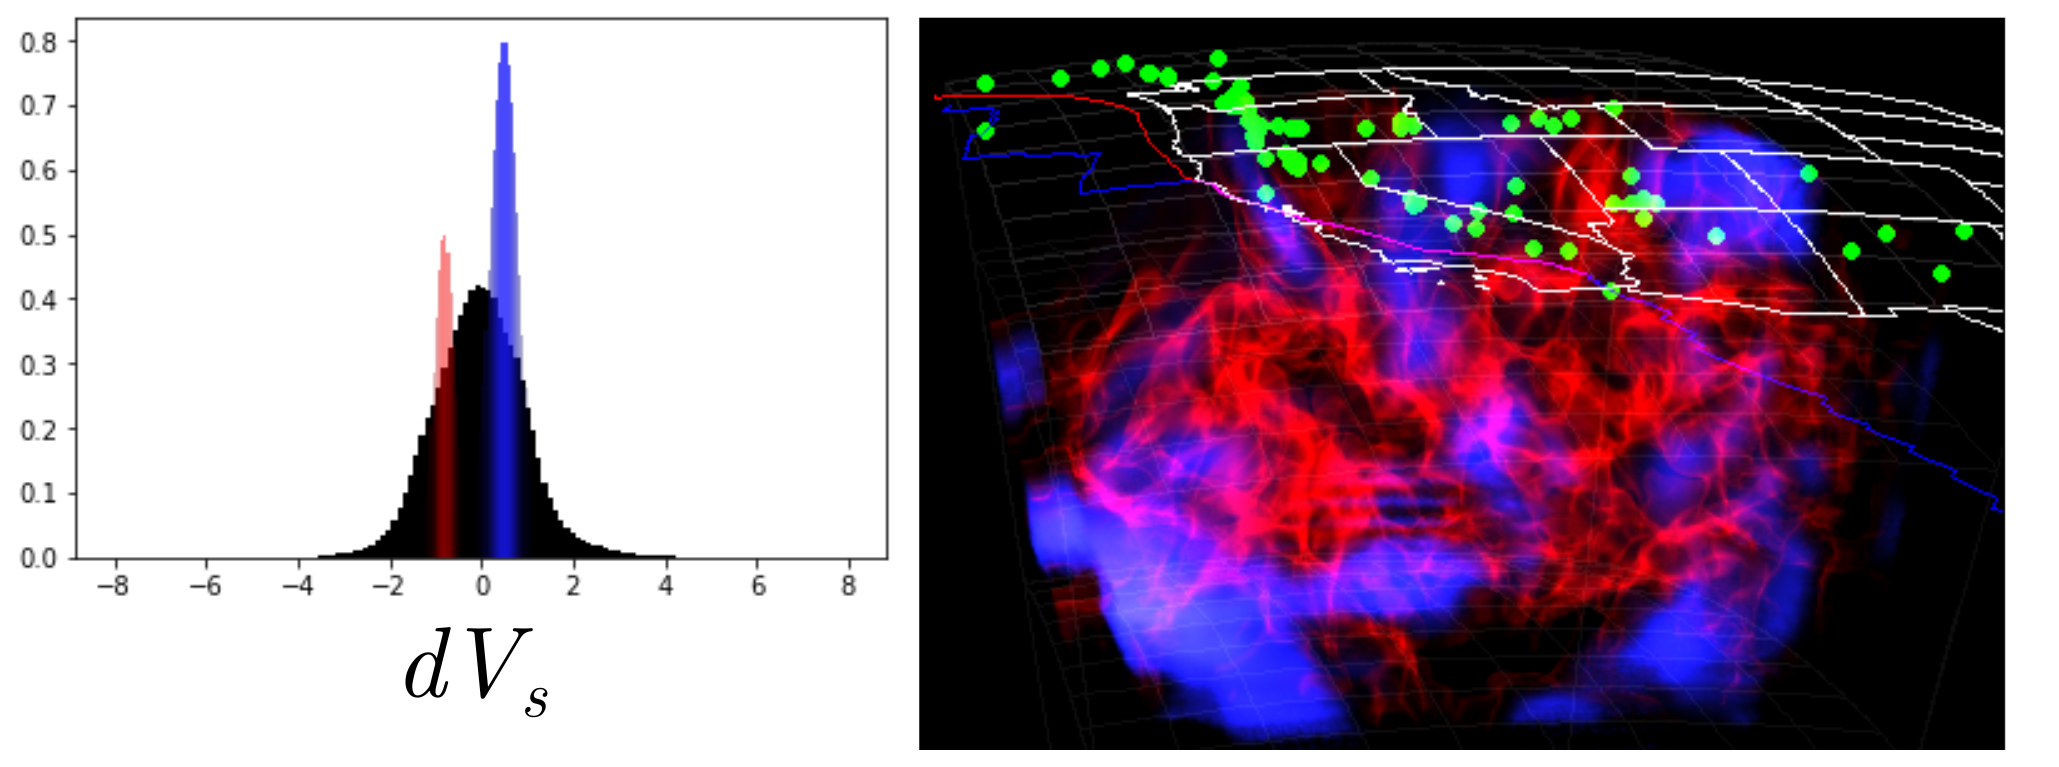

In [5]:
Image(filename = os.path.join('resources','TFexample.png'))

The transfer function plot (left) contains a normalized histogram of the velocity anomaly, $dV_s$, over the whole domain, in black. The red and blue guassians represent the transfer function: the y-axis corresponds to the transmission coefficient (0 for transparent, 1 for opaque) and the $dV_s$ values falling within each respective gaussian are assigned the corresponding RGB value. 

The given transfer function results in the volume rendering to the right. The blues correspond to the range of positive velocity anomalies bounded by the blue gaussian in the transfer function plot, while the reds correspond to the slow velocity anomalies bounded by the red guassian. 

In the following sections, we demonstrate how to create the above figure, and then how to modify the transfer function in more complex ways.

### 5.1 Transfer Functions: yt presets

*yt* provides a variety of preset transfer functions, but first, we define a simple function to pull out the values from a given transfer function to plot on top of a histogram of the data:

In [6]:
def plotTf_yt(tf,dvs_min,dvs_max):     
    x = np.linspace(dvs_min,dvs_max,tf.nbins) # RGBa value defined for each dvs bin in range
    y = tf.funcs[3].y # the alpha value of transfer function at each x 
    w = np.append(x[1:]-x[:-1], x[-1]-x[-2]) 
    colors = np.array([tf.funcs[0].y, tf.funcs[1].y, tf.funcs[2].y,
                       tf.funcs[3].y]).T
    fig = plt.figure()
    ax = fig.add_axes([0.2, 0.2, 0.75, 0.75])
    d_hist=ax.hist(data['dvs'][~np.isnan(data['dvs'])].ravel(),bins=100,density=True,log=False,color='k')
    ax.bar(x, tf.funcs[3].y, w, edgecolor=[0.0, 0.0, 0.0, 0.0],
           log=False, color=colors, bottom=[0])
    plt.show()

One of the simplest *yt* trasnfer function methods is to add a gaussian to highlight a narrow range of the data. The user initializes a transfer function, and then adds a gaussian described by the center of the peak, the peak width and the RGBa value of the center point:

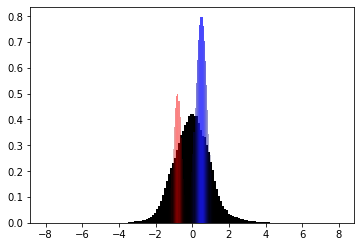

In [7]:
# initialize the tf object by setting the data bounds to consider
dvs_min=-8
dvs_max=8 
tf = yt.ColorTransferFunction((dvs_min,dvs_max))

# set gaussians
TF_gaussians=[
    {'center':-.8,'width':.1,'RGBa':(1.,0.,0.,.5)},
    {'center':.5,'width':.2,'RGBa':(0.1,0.1,1.,.8)}
]

for gau in TF_gaussians:
    tf.add_gaussian(gau['center'],gau['width'],gau['RGBa'])
    
# plot the transfer function     
plotTf_yt(tf,dvs_min,dvs_max)

Once the transfer function is set, the volume rendering can be created. Because we will explore different transfer functions below, we first define a function to build the yt scene object, using functions defined in the previous section.

In [8]:
def configure_scene(the_transfer_function):
    # build scene, apply camera settings, set the transfer function 
    sc = build_yt_scene() 
    setCamera(sc)
    source = sc.sources['source_00']
    source.set_transfer_function(the_transfer_function)
    print("Scene ready to render")
    return sc

Given a transfer function, we can then run all the steps required before final rendering with:

In [9]:
sc = configure_scene(tf)

Scene ready to render


The scene is now ready to render, which is done by calling `sc.show()`.

yt : [INFO     ] 2020-05-12 09:18:44,872 Rendering scene (Can take a while).
yt : [INFO     ] 2020-05-12 09:18:45,003 Creating volume
/home/chavlin/miniconda3/envs/yt_vis/lib/python3.7/site-packages/yt/units/yt_array.py:1373: RuntimeWarning: invalid value encountered in log10
  out_arr = func(np.asarray(inp), out=out, **kwargs)


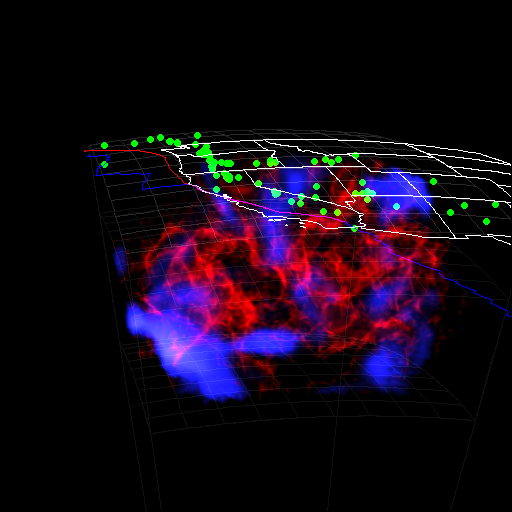

In [10]:
sc.show(sigma_clip=1.5)

Note that the argument `sigma_clip=1.5` controls the contrast of the final image, which is useful for fine tuning the final brightness of the image (e.g., https://yt-project.org/doc/cookbook/complex_plots.html#cookbook-sigma-clip). 

### 5.2 Transfer Functions: Customization

Because the transfer function object is a 4D numpy array of RGBa values, it is straightforward to create custom transfer functions for a particular application. Here, we demonstrate a more complex transfer function built to clearly differentiate slow and fast anomalies over a wider range of data than the gaussian example. This example uses some transfer function routines from the `yt_velmodel_vis.transfer_functions` module and so we define a new plotting function before building the transfer function:

In [11]:
def plotTf(tfOb):
    """ create a histogram-transfer function plot and display it"""
    f=plt.figure()
    ax=plt.axes()
    ax=tfOb.addHist(ax=ax,density=True,color=(0.,0.,0.,1.))
    ax=tfOb.addTFtoPlot(ax=ax)
    ax.set_xlabel('dvs')        
    plt.show()

Now that we have a way to visualize transfer functions, we can build a transfer function. This example divides the transfer function into two separate segments of the data using entirely different colormaps. Within each segment, the transmission coefficient is inversely proportional to the number of observations in that $dV_s$ bin,

$\alpha(dV_s^i) = \alpha_0 - \Delta{\alpha} \frac{N(dV_s^i)}{\mathrm{max}(N(dV_s))}$

where $\alpha_0$ is the maximum transmission coefficient, $\Delta{\alpha}$ is the reduction in transmission coefficient, $N(dV_s)$ is value of the normalized histogram of $dV_s$ observations and $N(dV_s^i)$ is the histogram evaluated at a single $dV_s$ value,  $dV_s^i$. 

This transfer function provides a convenient means to render a wider data range without overwhelming the image with the anomalies near 0.

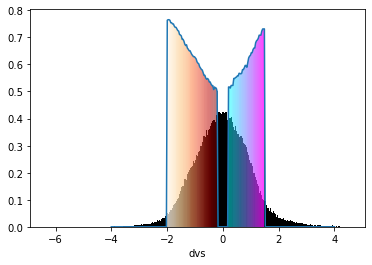

Ready to build scene


In [12]:
# setting up transfer functions 
tfOb = TFs.dv(data[datafld].ravel(),bounds=[-4,4])

def alphaHist(histData,maxAlpha,alphaFac):
    if alphaFac>maxAlpha:
        alphaFac=maxAlpha
    return maxAlpha - alphaFac*histData/histData.max()

bnds=[-2,-.2]
TFseg=TFs.TFsegment(tfOb,bounds=bnds,cmap='OrRd')
histData,_=tfOb.calcHist(bin_edges=TFseg.dvbins)
tfOb.addTFsegment(alphaHist(histData,.8,0.3),TFseg)

bnds=[.2,1.5]
TFseg=TFs.TFsegment(tfOb,bounds=bnds,cmap='cool')
histData,_=tfOb.calcHist(bin_edges=TFseg.dvbins)
tfOb.addTFsegment(alphaHist(histData,.8,0.3),TFseg)

plotTf(tfOb)
print("Ready to build scene")


The `TFs.TFsegment` object is defined for any range of bounds within the total transfer function (i.e., in this example, the initial transfer function is defined for -4 to 4, the slow segment from -2 to -.2, fast from .2 to 1.5) and any of the colormaps available in *yt* may be specified (https://yt-project.org/doc/visualizing/colormaps/index.html#displaying-colormaps-locally). 

Once the transfer function is built, we once again build the scene, supplying our custom transfer function, and render:

In [13]:
# build scene, apply camera settings, set the transfer function 
sc = configure_scene(tfOb.tf)

Scene ready to render


yt : [INFO     ] 2020-05-12 09:18:47,722 Rendering scene (Can take a while).
yt : [INFO     ] 2020-05-12 09:18:47,952 Creating volume


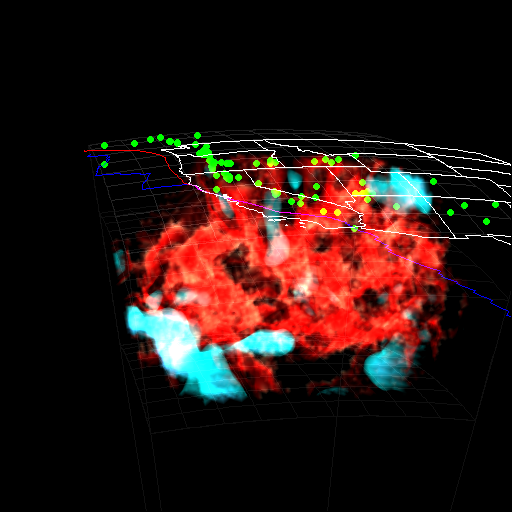

In [14]:
sc.show(sigma_clip=1) # render the scene 

Comparing this rendering to the example with separate gaussians... 

## References

* Coffin, M.F., Gahagan, L.M., and Lawver, L.A., 1998, Present-day Plate Boundary Digital Data Compilation. University of Texas Institute for Geophysics Technical Report No. 174, pp. 5., http://www-udc.ig.utexas.edu/external/plates/data.htm
* IRIS EMC: http://ds.iris.edu/ds/products/emc-earthmodels/
* James D.E., M.J. Fouch, R.W. Carlson and J.B. Roth. 2011. “Slab fragmentation, edge flow and the origin of the Yellowstone hotspot track.” Earth Planet. Sci. Lett., https://doi.org/10.1016/j.epsl.2011.09.007. Data retrieved from http://ds.iris.edu/ds/products/emc-nwus11-s/ 
* Natural Earth, https://www.naturalearthdata.com/ 
* Obrebski, M., R.M. Allen, M. Xue, and Shu-Huei Hung. 2010. “Slab-Plume Interaction beneath the Pacific Northwest.” Geophys. Res. Lett. 37:L14305. https://doi.org/10.1029/2010GL043489.
* Simkin and Siebert. "Volcanoes of the world: An illustrated catalog of Holocene volcanoes and their eruptions." (1994), https://earthworks.stanford.edu/catalog/harvard-glb-volc
* Trabant, C., A. R. Hutko, M. Bahavar, R. Karstens, T. Ahern, and R. Aster (2012), Data Products at the IRIS DMC: Stepping Stones for Research and Other Applications, Seismological Research Letters, 83(5), 846–854, https://doi.org/10.1785/0220120032.
* *yt*: https://yt-project.org 
* yt_velmodel_vis: https://github.com/chrishavlin/yt_velmodel_vis

